In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.python.framework.ops import EagerTensor
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

In [2]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')
vgg.trainable = False
pp.pprint(vgg)

<Functional name=vgg19, built=True>


The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


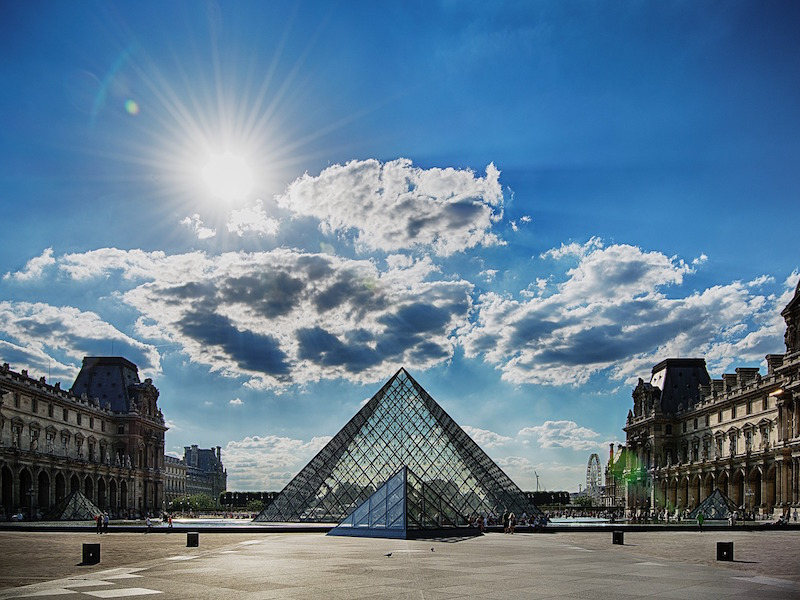

In [3]:
content_image = Image.open("../images/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

In [4]:
# UNQ_C1
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    shape=tf.shape(a_G)
    n_H,n_W,n_C = shape[1],shape[2],shape[3]
    denom = tf.cast(4 * n_H * n_W * n_C, tf.float32)
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(tf.transpose(a_C, perm=[0, 3, 1, 2]), shape=(-1, n_C, n_W * n_H))
    a_G_unrolled = tf.reshape(tf.transpose(a_G, perm=[0, 3, 1, 2]), shape=(-1, n_C, n_W * n_H))
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))/denom
    
    ### END CODE HERE
    
    return J_content

In [5]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost(a_C, a_G)
J_content_0 = compute_content_cost(a_C, a_C)
assert type(J_content) == EagerTensor, "Use the tensorflow function"
assert np.isclose(J_content_0, 0.0), "Wrong value. compute_content_cost(A, A) must be 0"
assert np.isclose(J_content, 7.0568767), f"Wrong value. Expected {7.0568767},  current{J_content}"

print("J_content = " + str(J_content))

# Test that it works with symbolic tensors
ll = tf.keras.layers.Dense(8, activation='relu', input_shape=(1, 4, 4, 3))
model_tmp = tf.keras.models.Sequential()
model_tmp.add(ll)
try:
    compute_content_cost(ll.output, ll.output)
    print("\033[92mAll tests passed")
except Exception as inst:
    print("\n\033[91mDon't use the numpy API inside compute_content_cost\n")
    print(inst)

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)

Don't use the numpy API inside compute_content_cost

A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


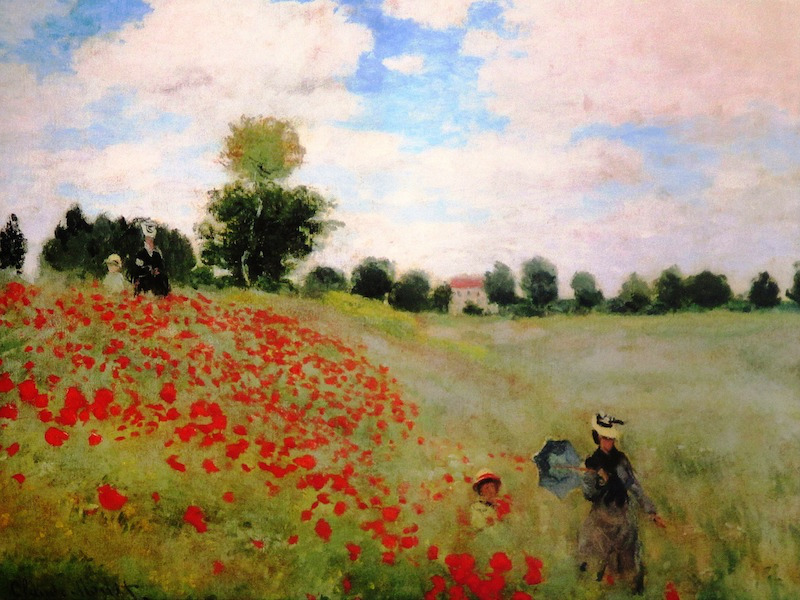

In [6]:
example = Image.open("../images/monet_800600.jpg")
example

In [7]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [8]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

assert type(GA) == EagerTensor, "Use the tensorflow function"
assert GA.shape == (3, 3), "Wrong shape. Check the order of the matmul parameters"
assert np.allclose(GA[0,:], [63.1888, -26.721275, -7.7320204]), "Wrong values."

print("GA = \n" + str(GA))

print("\033[92mAll tests passed")

GA = 
tf.Tensor(
[[ 63.1888    -26.721277   -7.7320204]
 [-26.721277   12.767579   -2.5158243]
 [ -7.7320204  -2.5158246  23.752384 ]], shape=(3, 3), dtype=float32)
All tests passed


In [9]:
def compute_layer_style_cost(a_S, a_G):
    shape=tf.shape(a_G)
    n_H, n_W, n_C = shape[1],shape[2],shape[3]
    
    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W) (≈2 lines)
    a_S = tf.reshape(tf.transpose(a_S, perm=[0, 3, 1, 2]), shape=(n_C, -1))
    a_G = tf.reshape(tf.transpose(a_G, perm=[0, 3, 1, 2]), shape=(n_C, -1))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    denom = tf.cast(4 * (n_H * n_W * n_C) ** 2, tf.float32)
    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) / denom
    #J_style_layer = None
    
    ### END CODE HERE
    
    return J_style_layer

In [10]:
for layer in vgg.layers:
    print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
vgg.get_layer('block5_conv4').output

<KerasTensor shape=(None, 25, 25, 512), dtype=float32, sparse=False, name=keras_tensor_20>

In [12]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [13]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

In [14]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    ### START CODE HERE
    
    #(≈1 line)
    J = alpha * J_content + beta * J_style
    
    ### START CODE HERE

    return J

(1, 400, 400, 3)


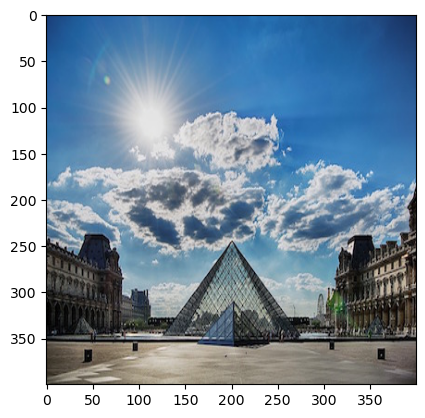

In [15]:
content_image = np.array(Image.open("../images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


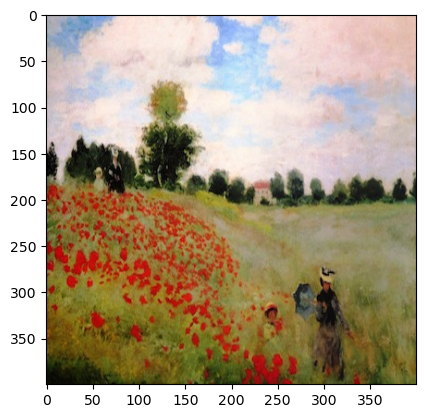

In [16]:
style_image =  np.array(Image.open("../images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


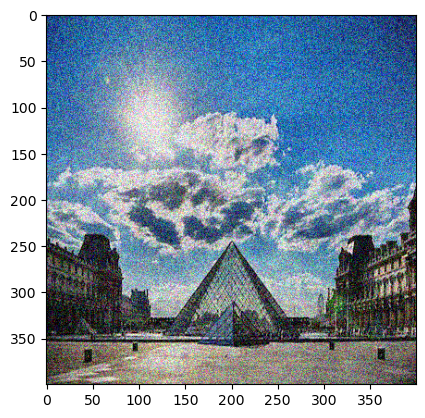

In [17]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [18]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [19]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [20]:
content_target = vgg_model_outputs([content_image])  # Content encoder
style_targets = vgg_model_outputs([style_image])     # Style enconder

In [21]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 400, 400, 3))
  warnings.warn(msg)


In [22]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [23]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        
        ### START CODE HERE
        
        #(1 line)
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G)

        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style, alpha=10, beta=40)
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J


In [33]:
generated_image = tf.Variable(generated_image)


J1 = train_step(generated_image)
print(J1)
assert type(J1) == EagerTensor, f"Wrong type {type(J1)} != {EagerTensor}"
assert np.isclose(J1, 25629.055, rtol=0.05), f"Unexpected cost for epoch 0: {J1} != {25629.055}"

J2 = train_step(generated_image)
print(J2)
assert np.isclose(J2, 17812.627, rtol=0.05), f"Unexpected cost for epoch 1: {J2} != {17735.512}"

print("\033[92mAll tests passed")

tf.Tensor(-318010620.0, shape=(), dtype=float32)


AssertionError: Unexpected cost for epoch 0: -318010624.0 != 25629.055

In [ ]:
epochs = 2501
import os
from IPython.display import clear_output, display
os.makedirs("../outputs", exist_ok=True)
for i in range(epochs):
    train_step() 
    if i % 250 == 0:
        print(f"Epoch {i}", flush=True)
        img = tensor_to_image(generated_image)
        fname = f"../outputs/image_{i}.jpg"
        img.save(fname)
        print("  saved:", fname)
        clear_output(wait=True)
        display(img)     